# Simulating a Transmon-Resonator system with **Qiskit Metal** Designs, **palace** and **SQDMetal**

This tutorial explores the simulation of [Qiskit Metal](https://github.com/qiskit-community/qiskit-metal)  `design` objects using `palace`, facilitated by `SQDMetal`. The design of quantum devices, the foundation of the quantum ecosystem, is a multi-step process. Qiskit Metal endeavors to simplify and organize this undertaking.

**About Qiskit Metal**

[Qiskit Metal](https://github.com/qiskit-community/qiskit-metal) 
 \( [docs here](https://qiskit-community.github.io/qiskit-metal/index.html), [tutorials here](https://qiskit-community.github.io/qiskit-metal/tut/index.html)  \)  aims to provide a community-driven platform for quantum chip development, from concept to layout to electromagentics to Hamiltonians and to fabrication, within an open framework. It aims to foster innovation and make the design of quantum devices more accessible.  By automating and building in best practices, testing on real devices, Metal aims to make quantum hardware modeling more straightforward, reduce errors, and improve design speed.  It was started and led by Zlatko Minev, developed with the IBM Qiskit Metal team and many open-source contributors. It employs the permissive Apache 2.0 license and is now a community-maintained open-source package.

 The [Qiskit Metal tutorials](https://qiskit-community.github.io/qiskit-metal/tut/index.html) and [20+ videos on YouTube](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqHl5ZqVmhB_FcSqmLufsjb) offer a good starting point for exploration.

**Contributing to the Future of Device Design**

The continued development of Qiskit Metal relies on its community. If you have an interest in quantum hardware and wish to contribute, consider becoming a maintainer or exploring funding opportunities. We invite you to the **Quantum Metal and device design session**. This will be a discussion with Zlatko Minev, Eli Levenson-Falk, and other key figures in the Metal community about its future, the formation of a board of directors, and a maintainer group. If contributing to this effort interests you, we encourage you to connect at this workshop and **join the Thursday workshop on the future of Metal.** 


**What This Tutorial Covers**

Here, we will walk through electrostatic and eigenmode simulations of a qubit-cavity system. We will use `palace`, an open-source finite element analysis tool, through the `SQDMetal` interface. While Qiskit Metal also supports other tools like Elmer, this guide focuses on the `palace` integration.

We will learn to:
1.  Define a qubit-cavity system in Qiskit Metal.
2.  Prepare this design for simulation with `SQDMetal`.
3.  Run electrostatic simulations in `palace` to examine charge distributions and capacitances.
4.  Conduct eigenmode simulations in `palace` to find resonant frequencies and mode profiles.

This tutorial aims to provide a working knowledge of how these open-source tools can be combined for the analysis of superconducting quantum circuits, helping to reveal the underlying physics at play.

**Requirements:**

* [ ] Ensure that [`SQDMetal`](https://github.com/sqdlab/SQDMetal) is installed in your environment. This package includes installation of Qiskit Metal.
* [ ] Ensure that [`palace`](https://github.com/sqdlab/palace) is installed in your environment. Instructions are [here](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html).

Let us begin the exploration.

In [15]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
from collections import OrderedDict
# from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import numpy as np
import matplotlib.pyplot as plt
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin
from SQDMetal.Utilities.Materials import MaterialInterface


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Transmon + Resonator System

Let's start discussing how a transmon qubit electrically look like. We can essentially identify a transmon qubit system with its control and readout system as a lumped electrical circuit. Below, we used a nice visualization package called "schemdraw" to draw an example transmon circuit.

In [6]:
# Install schemdraw if you haven't already: !pip install schemdraw
import schemdraw
import schemdraw.elements as elm
import schemdraw.flow as flow

 /opt/homebrew/anaconda3/envs/sqdmetal_env/lib/python3.11/site-packages/schemdraw/backends/mpl.py: 79


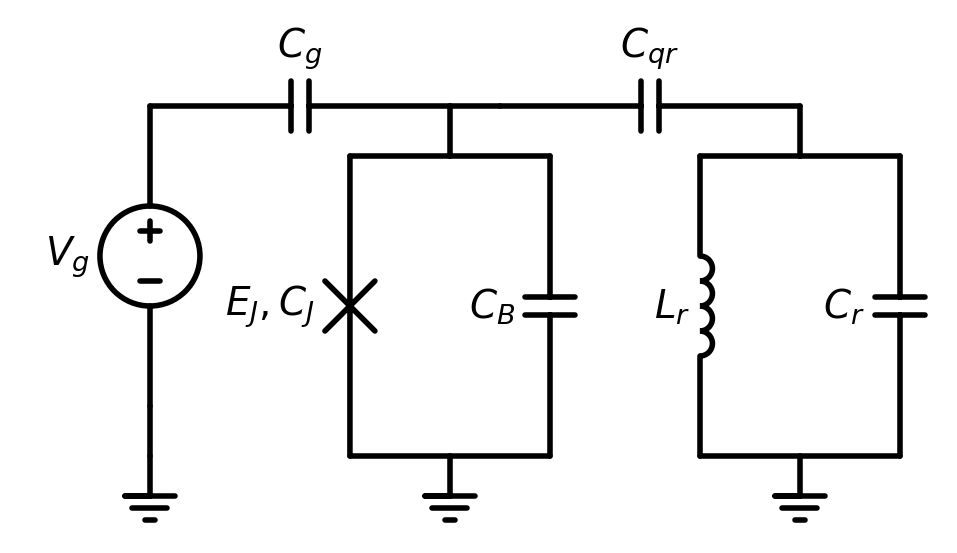

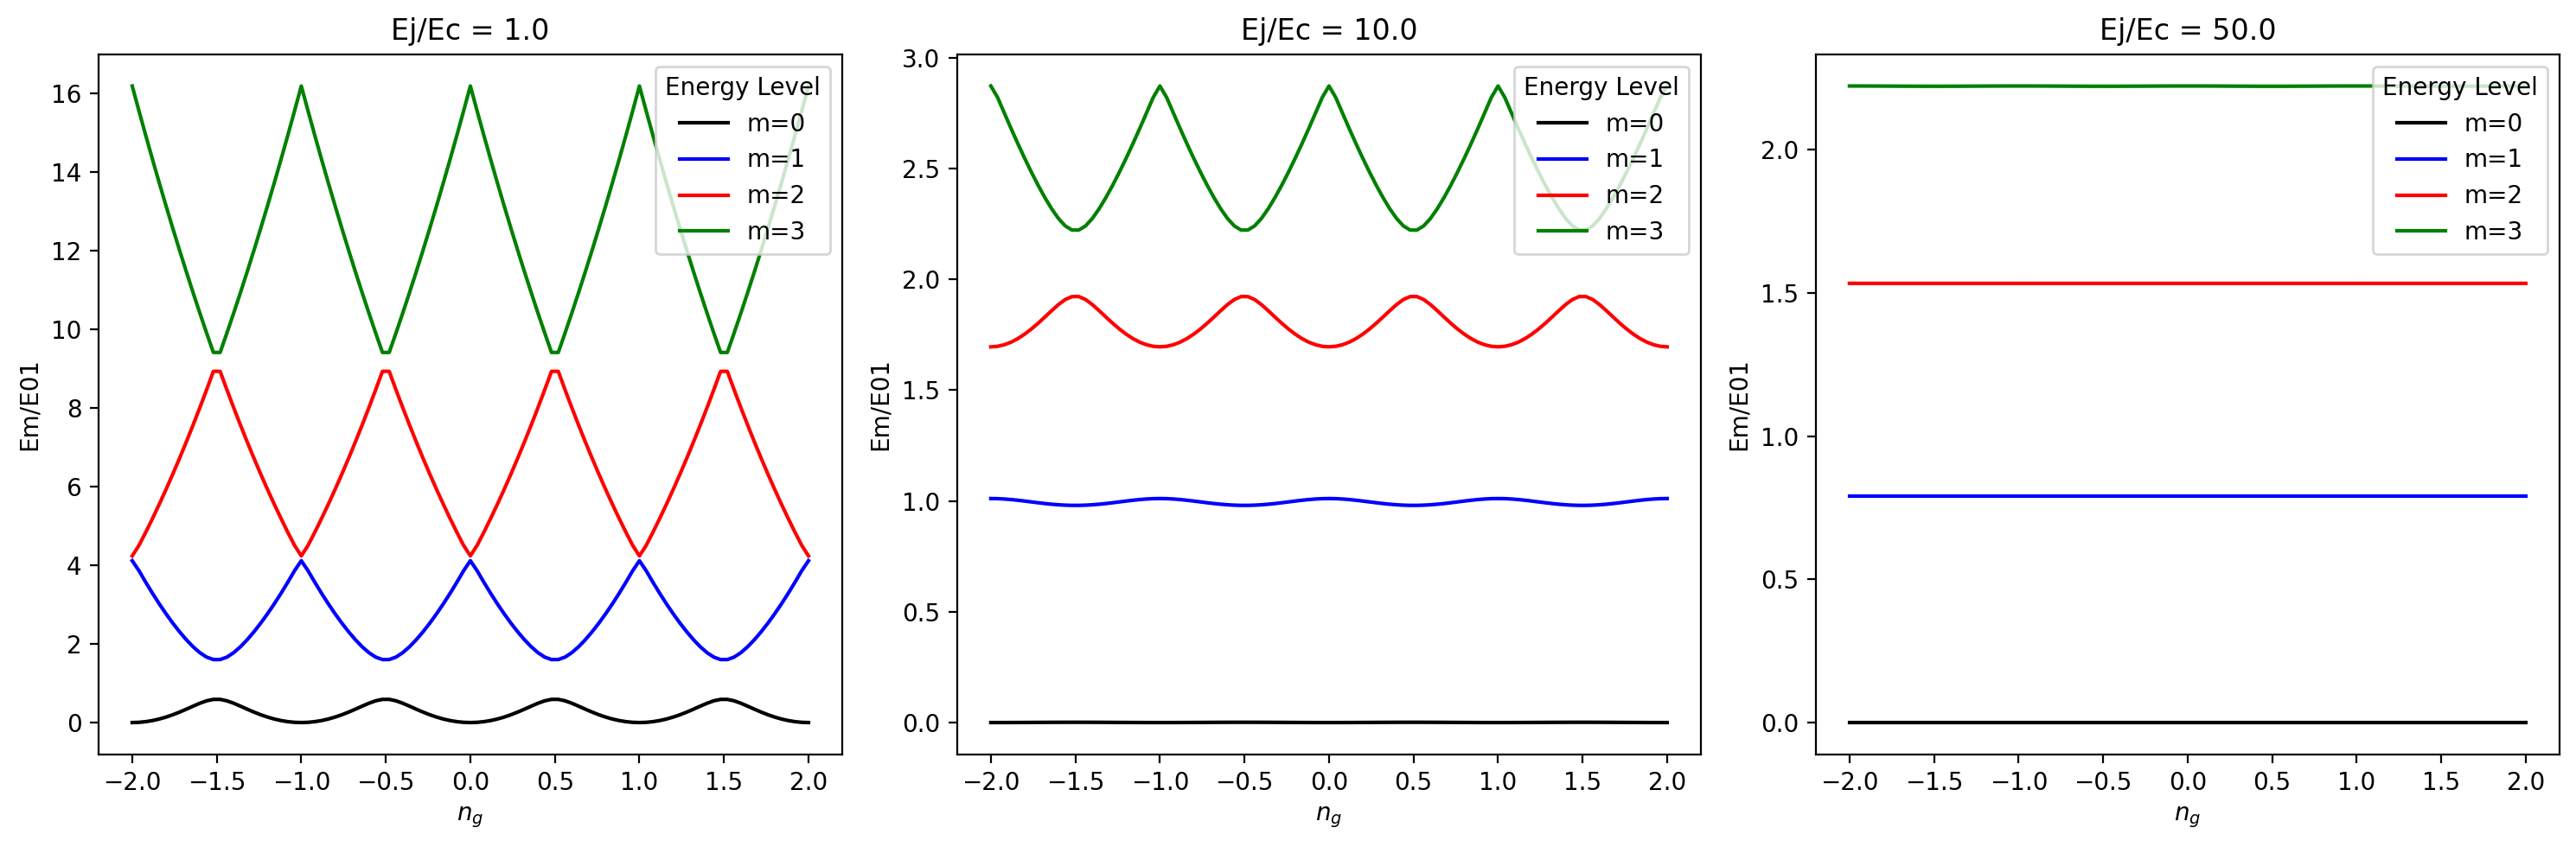

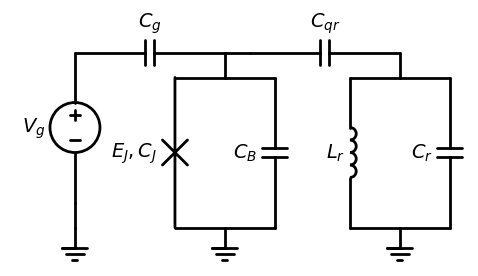

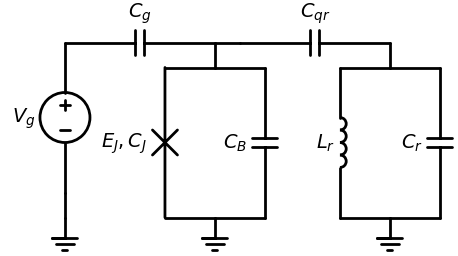

In [7]:
# Create a new drawing
d = schemdraw.Drawing()

# --- Define Nodes ---
bottom_node = (0,0) # Common ground node

# --- Draw the Transmon (Qubit) Circuit ---
# Drawing the charge line
d += elm.Ground().at(bottom_node)
d += elm.Line().up().length(0.5)
d += elm.SourceV().up().label('$V_g$')
d += elm.Capacitor().right().label('$C_g$')

# Drawing the qubit circuit
charge_node = d.here
d += elm.Line().down().length(0.5)
junction_node = d.here
d += elm.Line().left().length(1)
d += elm.Josephson().down().label('$E_J, C_J$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(junction_node)
d += elm.Capacitor().down().label('$C_B$')
d += elm.Line().left().length(1)
d += elm.Ground()
d += elm.Line().right().length(0.5).at(charge_node)
d += elm.Capacitor().right().label('$C_{qr}$')

# Drawing the resonator circuit
d += elm.Line().down().length(0.5)
resonator_node = d.here
d += elm.Line().left().length(1)
d += elm.Inductor().down().label('$L_r$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(resonator_node)
d += elm.Capacitor().down().label('$C_r$')
d += elm.Line().left().length(1)
d += elm.Ground()
d.draw()

A basic structure for a single qubit system can be drawn as above. We have the transmon at the center of the circuit, defined by the parallel branch of Josepshon junction and a shunting capacitor. We have added a capacitively-coupled control line to the left, which creates charge fluctuations on our qubit. In order to readout the quantum state of the qubit, we have coupled our qubit to a resonator, which is modeled as an LC resonator capacitively coupled from the right. We will use the dispersive readout concepts we learned throughout the workshop to design our readout circuit.

Our first task is determining the properties of our transmon. We will start with designing the Hamiltonian of the transmon.
The transmon Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The  are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensionless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


Using the operator relations above, we can write the transmon Hamiltonian in the charge ($\hat n$) basis as given below, where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$


Writing the transmon Hamiltonian this way will help us to easily diagonalize the Hamiltonian and extract our qubit resonances.

### Charge Dispersion

Let's model the hamiltonian to see how the energy structure looks like. For this purpose, we can either use the Hcpb class within Qiskit Metal, or we can use the open source scqubits package. 


 Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degeneracy point where ng=0.5. For this exercise, first we'll take Josephson Energy to be equal to the charging energy and then we will check how our system behaves for different Josephson energies.

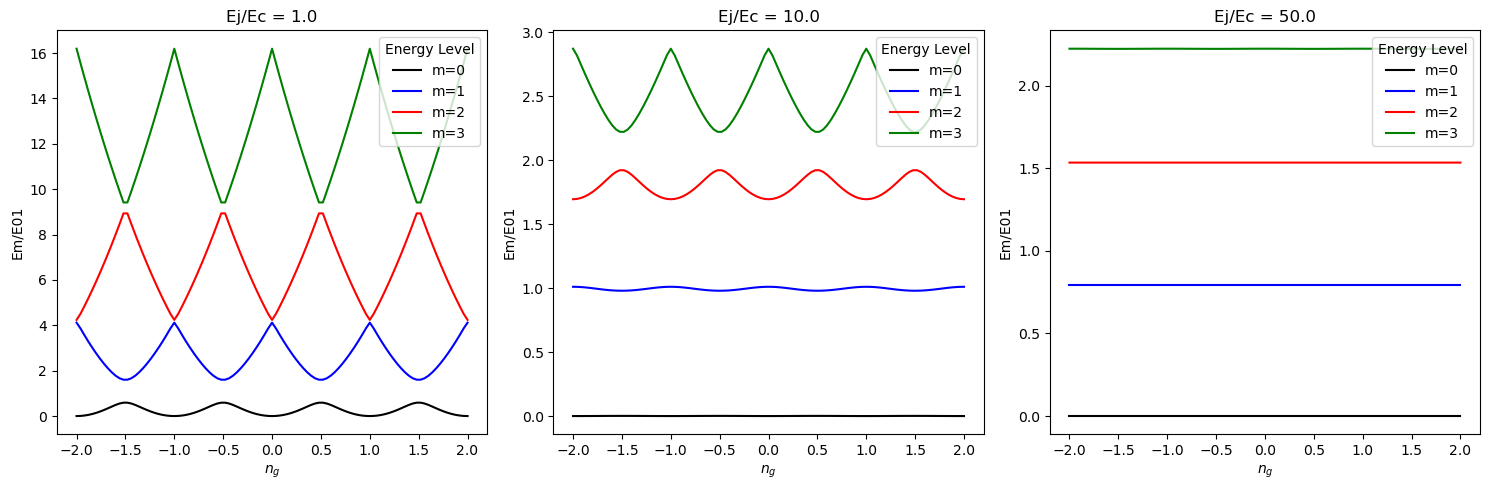

In [8]:

# Define the charging energies to iterate over
ng = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
E_c = 220
E_j_values = [E_c * 1, E_c * 10, E_c*50]
# Create a figure with subplots
fig, axes = plt.subplots(1, len(E_j_values), figsize=(15, 5))

# Iterate over the charging energies
for ax_idx, E_j in enumerate(E_j_values):
    epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []
    # Calculate charge dispersion for each Ej/Ec ratio
    for i in ng:
        H = Hcpb(nlevels=10, Ej=E_j, Ec=E_c, ng=i)
        H_norm = Hcpb(nlevels=2, Ej=E_j, Ec=E_c, ng=0.5)
        norm = H_norm.fij(0,1) # normalization constant
        epsilon0.append(H.evalue_k(0)/norm)
        epsilon1.append(H.evalue_k(1)/norm)
        epsilon2.append(H.evalue_k(2)/norm)
        epsilon3.append(H.evalue_k(3)/norm)
    floor = min(epsilon0)
    # Plot the charge dispersion on the current subplot
    ax = axes[ax_idx]
    ax.plot(ng, epsilon0-floor, 'k', label="m=0")
    ax.plot(ng, epsilon1-floor, 'b', label="m=1")
    ax.plot(ng, epsilon2-floor, 'r', label="m=2")
    ax.plot(ng, epsilon3-floor, 'g', label="m=3")
    ax.set_xlabel("$n_g$")
    ax.set_ylabel("Em/E01")
    ax.set_title(f"Ej/Ec = {E_j/E_c}")
    ax.legend(title="Energy Level", loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In the figures above, we see that the change in the frequency with the offset charges reduce with increasing $E_J/E_C$ ratio. This is very important for the coherence of our qubits, since the charge noise present in your environment would couple to your qubit anytime and cause frequency fluctuations. These frequency fluctuations cause incoherence for your qubits.


As we see here, for a transmon with equal inductive and capacitive energy, we observe huge swings in frequency with the gate charge, which is called charge dispersion.The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{m}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels.

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [9]:
E_c=220.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [10]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

We can plot these values to see the exponential decrease in the charge dispersion with increasing $E_{J}/E_{C}$. The important feature of a transmon qubit is insensitivity to the charge noise due to large $E_J/E_C$ ratio. This is ensured by adding a parallel capacitance $C_B$ to the josephson junction.

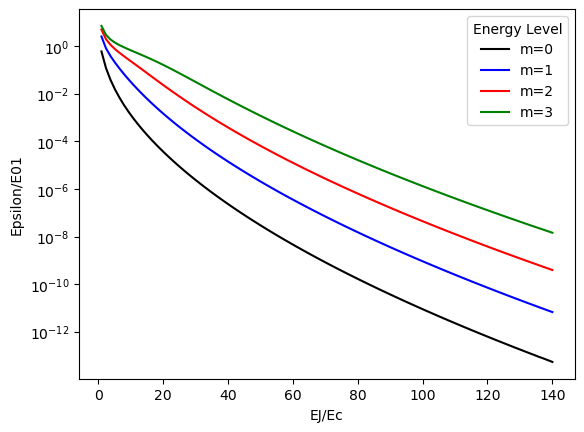

In [11]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel("EJ/Ec")
plt.ylabel("Epsilon/E01")
plt.legend(title="Energy Level", loc='upper right')

Now, let's use another useful package called scqubits to calculate our transmon qubit frequencies. scqubits will help us to diagonalize our hamiltonian and extract the resonance of the qubit

In [12]:
import scqubits as scq

qubit = scq.Transmon(
    EJ=13.2, # GHz, Josephson energy
    EC=0.22, # GHz, charging energy
    ng=0.001, # offset charge
    ncut=40, # number of levels to consider
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
print(f"Frequency of 01 transition = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"Anharmonicity = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

Frequency of 01 transition = 4588 MHz
Anharmonicity = -249 MHz


We set our qubit to have an $E_J/E_C$ ratio of 60. Let's have a look at how our qubit wavefunction looks like in terms of charge and flux basis.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

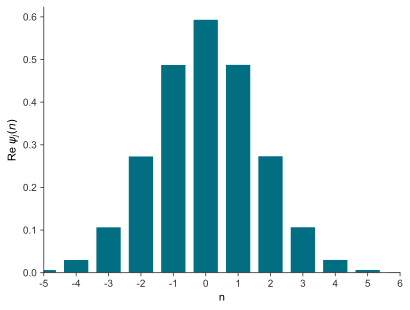

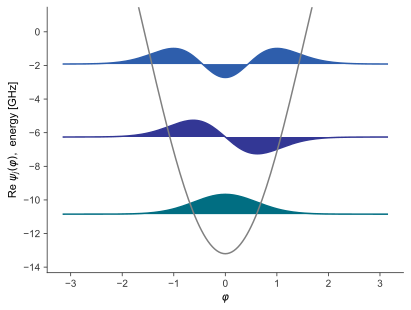

In [16]:
#Plot the wavefunction in charge and flux basis
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')

As we see, our qubit wavefunction is highly delocalized in the charge basis, while it is localized in flux basis within the cosine potential due to Josephson junction. This delocalization helps us to be independent from the offset gate charge fluctuations.

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

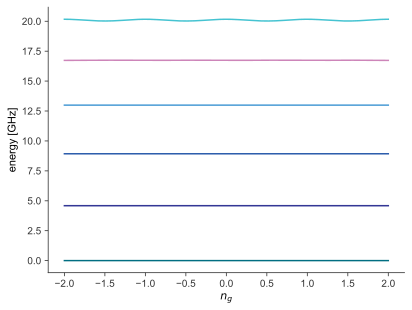

In [17]:
#Again, we can plot the eigenvalues as a function of gate charges to get an idea of charge dispersion.
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=True);

As we see from the wavefunction in the flux basis, we can identify our transmon as a weakly anharmonic oscillator in flux basis and diagonalize the Hamiltonian to obtain our energy eigenstates in terms of ladder operations $\hat{b}$ and $\hat{b}^{\dag}$, i.e. number of excitations. 

In this case, our Hamiltonian becomes:

$$
\hat{H}= \hbar\omega_q \hat{b}^{\dag}\hat{b}-\frac{E_C}{2} \hat{b}^{\dag}\hat{b}^{\dag}\hat{b}\hat{b}
$$
where, $\hbar\omega_q = \sqrt{8E_CE_J}-E_C$, which corresponds to the transition frequency between ground and first excited state. This transition is where quantum states are logically assigned.

The second component of the Hamiltonian depends on number of excitations present, which changes the transition frequency between higher excited states. This term is what makes our transmon oscillator anharmonic, where transition frequencies between each level are different from each other. The anharmonicity(or qubit nonlinearity) $\alpha$ is approximately equal to $E_C$, and helps us to distinguish between different qubit transitions, which is important for high-fidelity control of the qubits and prevent leakage to higher order transitions.

While designing a qubit, the important considerations are:
- Determine $E_J$ and $E_C$ according to the desired qubit frequency
- Having a large enough $E_J/E_C$ ratio to suppress the effects of charge noise
- Finally, having an appropriate $E_C$ (~100-400 MHz) to achieve better control and prevent leakage.

In summary, the $E_J$ and $E_C$ values are not independent from each other and should be carefully determined according to the qubit frequency regime desired for operation.

# Tunable Transmon

State of the art transmon devices are designed to have a tunable frequency, in order to be able to tune qubit properties to have best coherence, or to bring two qubits in resonance for achieving high-fidelity two qubit gate operations. For this purpose, the single Josephson Junction in transmon is replaced by a SQUID loop of two parallel Josephson Junctions. Such a qubit can be tuned by applying an external magnetic field within the loop. 

The flux sensitivity of tunable transmons can be reduced at the expense of tunable range, which improves coherence of the qubit under the presence of flux noise.

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

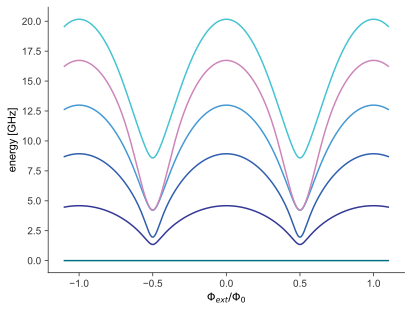

In [18]:
tune_tmon = scq.TunableTransmon(
    EJmax=13.2,
    EC=0.22,
    d=0.1,
    flux=0.0,
    ng=0.0,
    ncut=40
)

flux_list = np.linspace(-1.1, 1.1, 220)
tune_tmon.plot_evals_vs_paramvals('flux', flux_list, subtract_ground=True);

# Capacitance simulation of the qubit

Let's start designing our qubit and simulating our qubit capacitances to obtain desired parameters using Palace.

In [19]:

design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 
# Lets create the qubit with a junction and a claw

### Qubit
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0.375mm', pos_y='-1.3',
                                    vBar_width='24um', hBar_width='24um', vBar_gap=f'{16}um', hBar_gap=f'{16}um',
                                    cross_width=f'{60*2+24}um', cross_height=f'{60*2+24}um',
                                    gap_up='24um', gap_left='24um', gap_right='24um', gap_down='24um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='24um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='4um', prong_length='10um', pin_gap_side='4um',
                                                gap_side='10um', pad_thickness='20um',
                                                gap_front='10um', gap_back='5um', trace_width='10um'))

# Check the design
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()

02:59AM 43s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  WARNING: Populating font family aliases took 90 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 



In [24]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 500,                              #number of solver iterations
                "mesh_max": 120e-6,                                #maxiumum element size for the mesh in mm
                "mesh_sampling": 150,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 10,                                      #number of CPU cores to use for simulation
                "palace_dir":"/Users/mcansarihan/qubit_design/palace/build/bin/palace"
                }

In [25]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

os.makedirs('sims', exist_ok=True)

In [26]:
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'transmon_cross_cap_sim',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

In [27]:
bounds = design.components["xmon"].qgeometry_bounds()
bounds

array([ 0.279, -1.396,  0.471, -1.204])

In [28]:
#Fine-mesh the transmon cross qubit region
cap_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=10e-3, mesh_max=125e-3)

In [29]:
cap_sim.prepare_simulation()

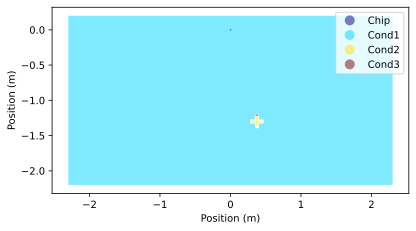

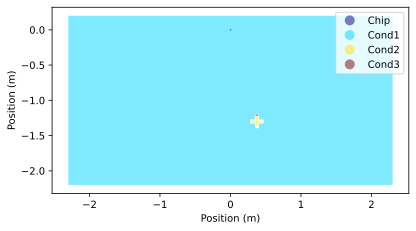

In [30]:
cap_sim.display_conductor_indices()

In [31]:
cap_matrix = cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin transmon_cross_cap_sim.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 28 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 1624 duplicate vertices for interior boundaries in the mesh
Added 3524 duplicate boundary elements for interior boundaries in the mesh
Added 740 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 5.520e-03 m, t₀ = 1.841e

In [33]:
cdf = pd.DataFrame(cap_matrix*1e15)

# get rid of the first column
cdf = cdf.iloc[:, 1:]

# assigning the columns and indices based on our geometry
cdf.columns = ["ground", "claw", "cross"]
cdf.index = ["ground", "claw", "cross"]
cdf

,ground,claw,cross
ground,4586.112126,-49.461276,-17.581026
claw,-49.461276,62.920761,-9.136881
cross,-17.581026,-9.136881,27.315604


In [74]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design)
c1.sim.capacitance_matrix = cdf


In [77]:
c1.setup.junctions = Dict({'Lj': 12.31, 'Cj': 2})
c1.setup.freq_readout = 7.0
# c1.setup.freq_bus = [6.0, 6.2]
c1.sim.capacitance_all_passes = {"0" : cdf}

c1.run_lom()

ValueError: Capacitance matrix is not the right size

## The Jaynes-Cummings model

The Jaynes-Cummings mode describes a system composed of a qubit (two-level system) coupled to a harmonic oscillator. The coupling is such that a qubit excitation can be "converted" into a photon and vice versa,

$\displaystyle H=-\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g (a\sigma_+ + a^\dagger \sigma_-)$

This model can be solved exactly, resulting in the following eigenenergies:

$\displaystyle E_0 = -\frac{1}{2}\omega_q$,

$\displaystyle E_{n\pm} =  \bigg(n-\frac{1}{2}\bigg) \omega_r \pm \sqrt{\frac{\Delta^2}{4}+n g^2}$,

where $\Delta=\omega_r-\omega_q$ and $n=1,2,\ldots$.

Let's simulate the transmon-resonator coupled system in scqubits first!

In [69]:
# exact eigenenergies for comparing with numerics

def energies(frequency_r, frequency_q, g, n_cutoff):
    delta = frequency_r - frequency_q
    energies1 = (np.arange(1, n_cutoff) - 0.5) * frequency_r
    energies2 = np.sqrt(delta**2/4 + np.arange(1, n_cutoff) * g**2)
    energies_plus = energies1 + energies2
    energies_minus = energies1 - energies2
    energies_0 = np.asarray([[-0.5 * frequency_q]])
    all_energies = np.append(energies_0, energies_minus)
    all_energies = np.append(all_energies, energies_plus)
    return np.sort(all_energies)

In [70]:
frequency_q = 1.0
frequency_r = 0.8
g = 0.1


qubit = scq.GenericQubit(E=frequency_q)

osc = scq.Oscillator(
    E_osc=frequency_r,
    truncated_dim=10  # up to 9 photons
)

In [9]:
# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([qubit, osc])

hilbertspace.add_interaction(
    g_strength = g,
    op1 = qubit.sm_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

In [71]:
evals = hilbertspace.eigenvals(evals_count=5)
print(evals)

[-0.5         0.25857864  0.54142136  1.02679492  1.37320508]


In [72]:
energies(frequency_r, frequency_q, g, 3)

array([-0.5       ,  0.25857864,  0.54142136,  1.02679492,  1.37320508])

# Drawing transmon + resonator system

In [50]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)



design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um',
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
readout = RouteMeander(design, 'readout',  Dict(
            total_length='6 mm',
            hfss_wire_bonds = True,
            fillet='90 um',
            lead = dict(start_straight='100um'),
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='readout'),
                end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()




In [51]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

In [52]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solns_to_save": 4,                                #number of electromagnetic field visualizations to save
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-4,                              #error residual tolerance for iterative solver
                "solver_maxits": 50,                              #number of solver iterations
                "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                "mesh_min": 1e-3,                                 #minimum element size for the mesh in mm
                "mesh_sampling": 120,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 2,                                      #number of CPU cores to use for simulation
                "palace_dir":"/Users/mcansarihan/qubit_design/palace/build/bin/palace"
                }


In [53]:
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'xmon_cap_sim_GMSH',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "/Users/mcansarihan/qubit_design/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
cap_sim.fine_mesh_in_rectangle(*list(design.components["Q1"].qgeometry_bounds()), mesh_sampling=130, mesh_min=15e-3, mesh_max=120e-3)

In [54]:
cap_sim.prepare_simulation()

In [55]:
cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 2 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin xmon_cap_sim_GMSH.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 2 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 949 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 292 duplicate vertices for interior boundaries in the mesh
Added 888 duplicate boundary elements for interior boundaries in the mesh
Added 12 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 2 subdomains

Characteristic length and time scales:
 L₀ = 2.400e-03 m, t₀ = 8.006e-03 ns

Me

array([[ 1.00000000e+00,  6.75587217e-11, -6.68258732e-11,
         0.00000000e+00, -7.18308917e-13],
       [ 2.00000000e+00, -6.68258732e-11,  6.79673978e-11,
        -1.88949731e-13, -8.95644528e-14],
       [ 3.00000000e+00,  0.00000000e+00, -1.88949731e-13,
         1.31275737e-12, -1.10660460e-12],
       [ 4.00000000e+00, -7.18308917e-13, -8.95644528e-14,
        -1.10660460e-12,  1.92569760e-12]])

In [56]:
import pandas as pd
import json
import pprint

def read_csv_to_dataframe(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)  # Skip the first row which is the header
    return df

def dataframe_to_json(df):
    # Convert values from F to fF
    df.iloc[:, 1:] *= 1e15

    # Extract values
    ground_to_ground = abs(df.iloc[0, 1])
    cross_to_ground = abs(df.iloc[1, 1])
    cross_to_cross = abs(df.iloc[1, 2])
    claw_to_ground = abs(df.iloc[2, 1])
    claw_to_cross = abs(df.iloc[2, 2])
    claw_to_claw = abs(df.iloc[2, 3])

    # Create the result dictionary
    result = {
        "claw_to_claw": claw_to_claw,
        "claw_to_ground": claw_to_ground,
        "cross_to_claw": claw_to_cross,
        "cross_to_cross": cross_to_cross,
        "cross_to_ground": cross_to_ground,
        "ground_to_ground": ground_to_ground,
        "units": "fF"
    }

    # Convert the result dictionary to JSON
    result_json = json.dumps(result, indent=4)
    return result_json


In [57]:
cap_matrix_df = read_csv_to_dataframe("/Users/mcansarihan/qubit_design/xmon_cap_sim_GMSH/outputFiles/terminal-C.csv")
cap_matrix = dataframe_to_json(cap_matrix_df)
pprint.pprint(json.loads(cap_matrix)) 

{'claw_to_claw': 1312.757368215,
 'claw_to_ground': 0.0,
 'cross_to_claw': 188.9497309427,
 'cross_to_cross': 67967.39778813,
 'cross_to_ground': 66825.87316149002,
 'ground_to_ground': 67558.72168877,
 'units': 'fF'}


In [ ]:
## Eigenmodal Simulationckages

design.delete_all_components
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 
# Lets create the qubit with a junction and a claw

### Qubit
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0.375mm', pos_y='-1.3',
                                    vBar_width='24um', hBar_width='24um', vBar_gap=f'{16}um', hBar_gap=f'{16}um',
                                    cross_width=f'{60*2+24}um', cross_height=f'{60*2+24}um',
                                    gap_up='24um', gap_left='24um', gap_right='24um', gap_down='24um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='24um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='4um', prong_length='10um', pin_gap_side='4um',
                                                gap_side='10um', pad_thickness='20um',
                                                gap_front='10um', gap_back='5um', trace_width='10um'))
# Now lets add the resonator and feedline
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='10um',
                                            trace_gap ='6um',
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))

#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='10um',
        trace_gap ='6um',
        total_length='3.7mm',
        hfss_wire_bonds = False,
        fillet='99.9 um',
        lead = dict(start_straight='300um'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))
# Check the design
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
# gui.screenshot('sims/qubit-cavity.png')
# Define the hyper-parameters for the eigenmode simulation
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 2e9,                              #starting frequency in Hz 
                 "number_of_freqs": 6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 3,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 10,                                      #number of CPU cores to use for simulation
                 "palace_dir":"/Users/mcansarihan/qubit_design/palace/build/bin/palace"
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files

# Assigning the materials to the interfaces, add ports to the design, and add some mesh.


eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6,)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=10e-9, C_J=10e-15)

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))
eigen_sim.prepare_simulation()
# Checking the meshfile
# gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
# gmsh_nav.open_GUI()
# If all looks good, lets run the simulation
eigen_sim.run()
# Reading the eigenmode data now
eigen_df = read_csv_to_dataframe("GMSH_eigen_test/outputFiles/eig.csv")
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

Logger issue: Internal C++ object (QTextEditLogger) already deleted.
>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin GMSH_eigen_test.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 2620 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 5317 duplicate vertices for interior boundaries in the mesh
Added 12451 duplicate boundary elements for interior boundaries in the mesh
Added 1554 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Cha



Verification failed: (port_excitation_helper.Empty()) is false:
 --> Eigenmode problems must not specify any excitation!
 ... in function: palace::SpaceOperator::SpaceOperator(const IoData &, const std::vector<std::unique_ptr<Mesh>> &)
 ... in file: /Users/mcansarihan/qubit_design/palace/palace/models/spaceoperator.cpp:63



Verification failed: (port_excitation_helper.Empty()) is false:
 --> Eigenmode problems must not specify any excitation!
 ... in function: palace::SpaceOperator::SpaceOperator(const IoData &, const std::vector<std::unique_ptr<Mesh>> &)
 ... in file: /Users/mcansarihan/qubit_design/palace/palace/models/spaceoperator.cpp:63



Verification failed: (port_excitation_helper.Empty()) is false:
 --> Eigenmode problems must not specify any excitation!
 ... in function: palace::SpaceOperator::SpaceOperator(const IoData &, const std::vector<std::unique_ptr<Mesh>> &)
 ... in file: /Users/mcansarihan/qubit_design/palace/palace/models/spaceoperator.cpp:63



Verification fail

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mcansarihan/GMSH_eigen_test/outputFiles/eig.csv'

## Eigenmodal Simulation

### For a qubit-cavity system

In [143]:
design.delete_all_components

<bound method QDesign.delete_all_components of <qiskit_metal.designs.design_planar.DesignPlanar object at 0x367607f50>>

In [144]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '4.6mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '8 um' #S
design.variables['cpw_gap'] = '4 um' #W 

Lets create the qubit with a junction and a claw

### Qubit

In [145]:
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0.375mm', pos_y='-1.6',
                                    vBar_width='24um', hBar_width='24um', vBar_gap=f'{16}um', hBar_gap=f'{16}um',
                                    cross_width=f'{60*2+24}um', cross_height=f'{60*2+24}um',
                                    gap_up='24um', gap_left='24um', gap_right='24um', gap_down='24um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='24um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='4um', prong_length='10um', pin_gap_side='4um',
                                                gap_side='10um', pad_thickness='20um',
                                                gap_front='10um', gap_back='5um', trace_width='10um'))

name:    claw
class:   CapacitorProngPin     
options: 
  'pos_x'             : '0.0um',                      
  'pos_y'             : '0.0um',                      
  'orientation'       : '0.0',                        
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'prong_width'       : '4um',                        
  'prong_length'      : '10um',                       
  'pin_gap'           : '6um',                        
  'pin_gap_side'      : '4um',                        
  'pad_thickness'     : '20um',                       
  'gap_side'          : '10um',                       
  'gap_front'         : '10um',                       
  'gap_back'          : '5um',                        
  'trace_width'       : '10um',                       
  'pin_inputs'        : {
       'start_pin'         : {
            'component'         : 'xmon',                       
            'pin'               : 'up',             

Now lets add the resonator and feedline

In [146]:
# Lauchpad 1
x1 = '-2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='10um',
                                            trace_gap ='6um',
                                            fillet='90um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))


In [147]:
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='8um',
        trace_gap ='4um',
        total_length='8mm',
        hfss_wire_bonds = False,
        fillet='60 um',
        lead = dict(start_straight='50um'),
        meander = dict( spacing='0.1mm'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))

12:59AM 10s WARNING [check_lengths]: For path table, component=resonator, key=trace has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.
12:59AM 10s WARNING [check_lengths]: For path table, component=resonator, key=cut has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.


Check the design

In [148]:
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
# gui.screenshot('sims/qubit-cavity.png')

12:59AM 12s WARNING [check_lengths]: For path table, component=resonator, key=trace has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.
12:59AM 12s WARNING [check_lengths]: For path table, component=resonator, key=cut has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.
12:59AM 12s WARNING [check_lengths]: For path table, component=resonator, key=trace has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.
12:59AM 12s WARNING [check_lengths]: For path table, component=resonator, key=cut has short segments that could cause issues with fillet. Values in (1-26)  are index(es) in shapely geometry.


Define the hyper-parameters for the eigenmode simulation

In [118]:
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 2e9,                              #starting frequency in Hz 
                 "number_of_freqs": 6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 1.0e-3,                              #error residual tolerance foriterative solver
                 "solver_maxits": 15,                              #number of solver iterations
                 "mesh_max": 30e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 0.1e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 2,                                      #number of CPU cores to use for simulation
                 "palace_dir":"/Users/mcansarihan/qubit_design/palace/build/bin/palace"
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files


Assigning the materials to the interfaces, add ports to the design, and add some mesh.

In [119]:
from SQDMetal.Utilities.Materials import MaterialInterface

eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
eigen_sim.fine_mesh_in_rectangle(0.2875e-3, -1.2e-3, 0.63e-3, -1.72e-3, min_size=15e-6, max_size=120e-6)

#Add in the RF ports
# eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
# eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
eigen_sim.create_port_JosephsonJunction('junction', L_J=10e-9, C_J=10e-15)

# #Fine-mesh routed paths
eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))

In [121]:
eigen_sim.prepare_simulation()

Checking the meshfile

If all looks good, lets run the simulation

In [122]:
eigen_sim.run()

>> /opt/homebrew/bin/mpirun -n 2 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin GMSH_eigen_test.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 2 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 4530 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 6283 duplicate vertices for interior boundaries in the mesh
Added 15331 duplicate boundary elements for interior boundaries in the mesh
Added 1554 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 2 subdomains

Characteristic length and time scales:
 L₀ = 5.520e-03 m, t₀ = 1.841e-02 ns

Reading the eigenmode data now

In [123]:
eigen_df = read_csv_to_dataframe("GMSH_eigen_test/outputFiles/eig.csv")
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

,m,Re{f} (GHz),Im{f} (GHz),Q,Error (Bkwd.),Error (Abs.),kappa (kHz)
0,1.0,2.225268,9.015895e-07,1.234081e+06,3.299713e-07,0.032782,1.803179e+00
1,2.0,5.589762,1.425258e-03,1.960965e+03,5.349942e-07,0.053151,2.850516e+03
2,3.0,6.600542,1.177308e-02,2.803240e+02,1.303543e-06,0.129506,2.354612e+04
3,4.0,6.852498,-1.269181e-02,2.699579e+02,1.057787e-06,0.105091,2.538358e+04
4,5.0,9.593270,-1.390200e-01,3.450682e+01,2.234280e-06,0.221978,2.780109e+05
5,6.0,11.025814,1.717793e+00,3.248012e+00,2.596539e-06,0.257971,3.394634e+06


In [125]:
mode_dict = eigen_sim.retrieve_mode_port_EPR_from_file(eigen_sim._output_data_dir)

#get particpation ratios and frequencies from the simulation
participation_ratios = mode_dict['mat_mode_port']
frequencies = mode_dict['eigenfrequencies']

In [128]:
participation_ratios

array([[ 1.33221416e-04],
       [ 6.66336246e+00],
       [-2.50411577e-01],
       [-8.84673171e-02],
       [ 3.77213038e-03],
       [ 1.66234744e-03]])